In [1]:
import tensorflow as tf
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

2024-04-18 17:29:04.997367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 17:29:04.997415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 17:29:05.292110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 17:29:05.641532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rpushpar/.local/lib/python3.1

Segmentation Models: using `tf.keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=14 #Number of classes for segmentation
EPOCH=100

In [3]:
#Capture training image info as a list
train_path = os.path.join(os.path.dirname(os.getcwd()), "ChestXDet/train_data/")

train_images = []

for directory_path in glob.glob(os.path.join(train_path, "data")):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(os.path.join(train_path, "mask")):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


In [4]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/home/rpushpar/.conda/envs/venv.unettf/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [5]:
#################################################
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [6]:
######################################################
#Reused parameters in all models

n_classes=14
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.legacy.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [7]:
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model1.summary())


history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=EPOCH,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('savemodels/res34_backbone_100epochs.hdf5')

2024-04-18 17:31:01.297946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79077 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Epoch 1/100


2024-04-18 17:31:09.310806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-18 17:31:09.751944: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 17:31:11.488229: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


171/171 [==============================] - 21s 43ms/step - loss: 1.0051 - iou_score: 0.3277 - f1-score: 0.3354 - val_loss: 1.0022 - val_iou_score: 0.4146 - val_f1-score: 0.4311
Epoch 2/100
171/171 [==============================] - 3s 20ms/step - loss: 0.9355 - iou_score: 0.4625 - f1-score: 0.4883 - val_loss: 0.9265 - val_iou_score: 0.4532 - val_f1-score: 0.4731
Epoch 3/100
171/171 [==============================] - 3s 20ms/step - loss: 0.9011 - iou_score: 0.4953 - f1-score: 0.5202 - val_loss: 0.9251 - val_iou_score: 0.4739 - val_f1-score: 0.4965
Epoch 4/100
171/171 [==============================] - 3s 20ms/step - loss: 0.8854 - iou_score: 0.5010 - f1-score: 0.5250 - val_loss: 0.8964 - val_iou_score: 0.5000 - val_f1-score: 0.5174
Epoch 5/100
171/171 [==============================] - 3s 19ms/step - loss: 0.8658 - iou_score: 0.4959 - f1-score: 0.5225 - val_loss: 0.8901 - val_iou_score: 0.4871 - val_f1-score: 0.5061
Epoch 6/100
171/171 [==============================] - 3s 19ms/step - l

/home/rpushpar/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
########################################################################
###Model 2
BACKBONE2 = 'efficientnetb4'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model2.summary())


history2=model1.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=EPOCH,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('savemodels/efficientnetb4_backbone_100epochs.hdf5')

Epoch 1/100
171/171 [==============================] - 6s 25ms/step - loss: 0.6122 - iou_score: 0.6156 - f1-score: 0.6569 - val_loss: 0.8748 - val_iou_score: 0.4849 - val_f1-score: 0.4876
Epoch 2/100
171/171 [==============================] - 3s 20ms/step - loss: 0.5909 - iou_score: 0.6702 - f1-score: 0.7105 - val_loss: 0.9744 - val_iou_score: 0.4706 - val_f1-score: 0.4742
Epoch 3/100
171/171 [==============================] - 3s 20ms/step - loss: 0.5792 - iou_score: 0.6805 - f1-score: 0.7220 - val_loss: 0.9399 - val_iou_score: 0.4350 - val_f1-score: 0.4479
Epoch 4/100
171/171 [==============================] - 3s 20ms/step - loss: 0.5792 - iou_score: 0.6337 - f1-score: 0.6722 - val_loss: 0.8176 - val_iou_score: 0.4861 - val_f1-score: 0.5011
Epoch 5/100
171/171 [==============================] - 3s 20ms/step - loss: 0.5543 - iou_score: 0.6153 - f1-score: 0.6514 - val_loss: 0.7559 - val_iou_score: 0.4303 - val_f1-score: 0.4551
Epoch 6/100
171/171 [==============================] - 3s 20

In [9]:
########################################################################
###Model 3
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics=metrics)

#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model3.summary())


history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=EPOCH,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

model3.save('savemodels/vgg16_backbone_100epochs.hdf5')


Epoch 1/100
171/171 [==============================] - 8s 32ms/step - loss: 0.9358 - iou_score: 0.4752 - f1-score: 0.4876 - val_loss: 0.9201 - val_iou_score: 0.4912 - val_f1-score: 0.5091
Epoch 2/100
171/171 [==============================] - 3s 17ms/step - loss: 0.9038 - iou_score: 0.5232 - f1-score: 0.5414 - val_loss: 0.9046 - val_iou_score: 0.5037 - val_f1-score: 0.5241
Epoch 3/100
171/171 [==============================] - 3s 17ms/step - loss: 0.8920 - iou_score: 0.4999 - f1-score: 0.5197 - val_loss: 0.8952 - val_iou_score: 0.4698 - val_f1-score: 0.4927
Epoch 4/100
171/171 [==============================] - 3s 17ms/step - loss: 0.8840 - iou_score: 0.4889 - f1-score: 0.5116 - val_loss: 0.8833 - val_iou_score: 0.4760 - val_f1-score: 0.4988
Epoch 5/100
171/171 [==============================] - 3s 17ms/step - loss: 0.8783 - iou_score: 0.4980 - f1-score: 0.5219 - val_loss: 0.8870 - val_iou_score: 0.4749 - val_f1-score: 0.4973
Epoch 6/100
171/171 [==============================] - 3s 17

ValueError: Unable to synchronously create dataset (name already exists)

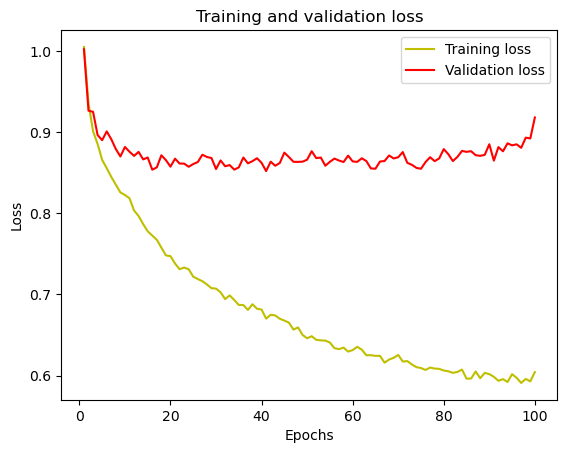

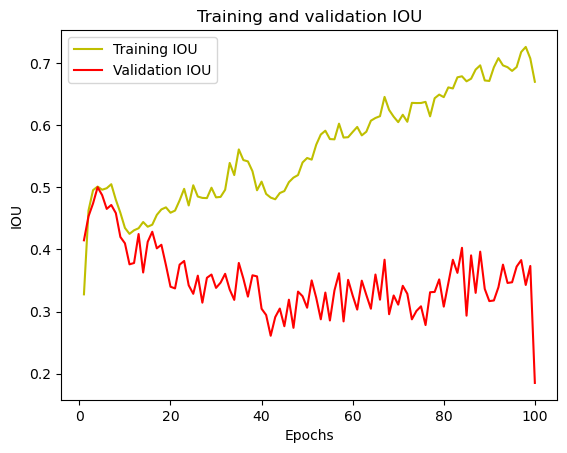

In [10]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

10/10 [==============================] - 2s 87ms/step
IOU Score for model1 =  0.12151079
IOU Score for model2 =  0.00015208764
IOU Score for model3 =  0.161865
IOU Score for weighted average ensemble =  0.11888309
Now predciting for weights : 0.0 0.0 0.0  : IOU =  0.065707944
Now predciting for weights : 0.0 0.0 0.1  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.2  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.3  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.4  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.5  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.6  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.7  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.8  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 0.9  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 1.0  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 1.1  : IOU =  0.161865
Now predciting for weights : 0.0 0.0 1.2  : IOU =  0.161865
Now

/tmp/ipykernel_3198463/2744945388.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
/tmp/ipykernel_3198463/2744945388.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  " w2=", max_iou_row[1], " and w3=", max_iou_row[2])
/tmp/ipykernel_3198463/2744945388.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  opt_weights = [max_iou_row[0], max_iou_row[1], ma

1/1 [==============================] - 0s 176ms/step


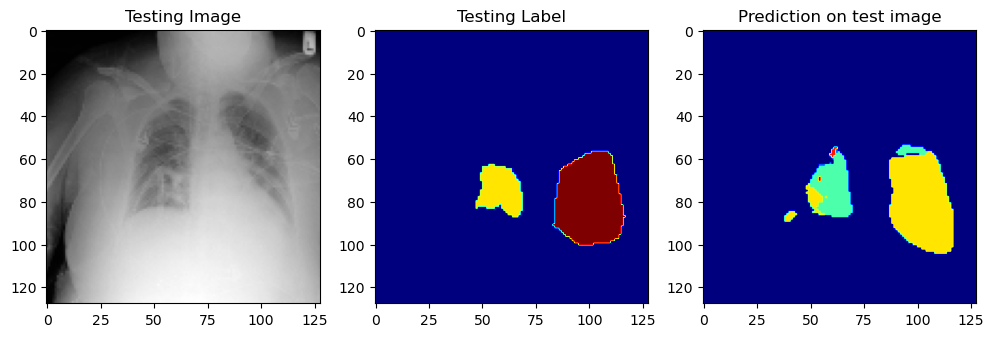

In [11]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('savemodels/res34_backbone_100epochs.hdf5', compile=False)
model2 = load_model('savemodels/efficientnetb4_backbone_100epochs.hdf5', compile=False)
model3 = load_model('savemodels/vgg16_backbone_100epochs.hdf5', compile=False)

#Weighted average ensemble
models = [model1, model2, model3]
#preds = [model.predict(X_test) for model in models]

pred1 = model1.predict(X_test1)
pred2 = model2.predict(X_test2)
pred3 = model3.predict(X_test3)

preds=np.array([pred1, pred2, pred3])

#preds=np.array(preds)
weights = [0.3, 0.5, 0.2]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)


#Using built in keras function
n_classes = 14
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)


print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())
###########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 14):
    for w2 in range(0,14):
        for w3 in range(0,14):
            wts = [w1/10.,w2/10.,w3/10.]
            
            IOU_wted = MeanIoU(num_classes=n_classes) 
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=3)
            IOU_wted.update_state(y_test[:,:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
            df = pd.concat([df, pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0])], ignore_index=True)
            
max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2])         


#############################################################
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]

#Use tensordot to sum the products of all elements over specified axes.
opt_weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
opt_weighted_ensemble_prediction = np.argmax(opt_weighted_preds, axis=3)
#######################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

#Weighted average ensemble
models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

#Use tensordot to sum the products of all elements over specified axes.
weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()